# Análisis del comportamiento de usuario

## Introducción

El análisis se enmarca en una empresa de venta de productos alimenticios. Se está investigando el comportamiento de los usuarios en la aplicación de la misma y también se desea estudiar si un cambio de diseño de la aplicación es conveniente para los usuarios o no. Para analizar dicho cambio se realizó una prueba A/A/B sobre los usuarios de los cuales también se obtuvo el registro de eventos.  

Para el estudio se cuenta con datos de eventos en la aplicación, en donde se han incluido también los grupos correspondientes a la prueba A/A/B realizada, datos proporcionados por la empresa.

## Objeto

El análisis tiene como objetivos:  
* Estudio del embudo de eventos: cómo los usuarios llegan a la etapa de compra, ¿cuántos usuarios realmente llegan a esta etapa?, ¿cuántos se atascan en etapas anteriores y en cuáles?  
* Análisis de prueba A/A/B: determinar cuál tipo de fuente en la aplicación es el preferido por los usuarios, el antiguo o el nuevo.

## 1. Importación de librerías y dataset

Se importan las librerías a utilizar en el análisis, y se lee a continuación el dataset con los datos remitidos por la empresa.

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth

In [71]:
df = pd.read_csv('./dataset/logs_exp_us.csv', sep='\t')
print(df.info())
print()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None



,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


## 2. Preparación de los datos

### 2.1 Nombres de columnas

Se decide cambiar los nombres de las columnas por unos que sean más convenientes, respetando la convención snake_case.

In [72]:
df.columns = ['event_name', 'user_id', 'event_time', 'group']
df.head()

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### 2.2 Detección de errores

Se define una función para detectar errores tales como valores ausentes ó valores duplicados.

In [73]:
def error_detection(df): #Función para detectar errores en dataset
    #Detección de valores ausentes por columna:
    for column in df:
        print(f'Valores ausentes en columna {column}:', df[column].isna().sum())
    print()
    #Detección de filas duplicadas:
    print('Cantidad de filas duplicadas:', df.duplicated().sum())
    print()
    return df

In [74]:
error_detection(df)

Valores ausentes en columna event_name: 0
Valores ausentes en columna user_id: 0
Valores ausentes en columna event_time: 0
Valores ausentes en columna group: 0

Cantidad de filas duplicadas: 413



,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Se observa:  
* No hay valores ausentes en las columnas.  
* Hay 413 filas duplicadas en un total de 244126, lo que representa un 0.17% de los valores. Por la muy baja incidencia de los mismos, se decide eliminarlos del dataset.  
* Se observa que los tipo de datos son correctos.

In [75]:
df.drop_duplicates(inplace=True)
print('Cantidad de filas duplicadas:', df.duplicated().sum())
print()
df.info()

Cantidad de filas duplicadas: 0

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  243713 non-null  object
 1   user_id     243713 non-null  int64 
 2   event_time  243713 non-null  int64 
 3   group       243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


### 2.3 Fechas

Se agregarán al dataframe una columna de fecha y hora y una columna separada para las fechas.

In [76]:
df['date_hour'] = pd.to_datetime(df['event_time'], unit='s')
df['date'] = df['date_hour'].dt.date
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

,event_name,user_id,event_time,group,date_hour,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  int64         
 3   group       243713 non-null  int64         
 4   date_hour   243713 non-null  datetime64[ns]
 5   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


## 3. Estudio y comprobación de los datos

### 3.1 Cantidad de eventos en los registros

Se calculará la cantidad de eventos por cada tipo de evento registrado, guardándolos en un nuevo dataframe de eventos.

In [78]:
events = df.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False).reset_index()
events.columns = ['event_name', 'event_count']
events

,event_name,event_count
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
2,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


### 3.2 Cantidad de usuarios en los registros

Se calcula la cantidad de usuarios que están en los registros en forma total, sin diferenciar por grupo de experimento. Luego se determina la cantidad de usuarios registrados en cada evento, generando un dataframe de usuarios.

In [79]:
print('Cantidad de usuarios en registros:', df['user_id'].nunique())
print()
users = df.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
users.columns = ['event_name', 'users']
users

Cantidad de usuarios en registros: 7551



,event_name,users
0,MainScreenAppear,7439
1,OffersScreenAppear,4613
2,CartScreenAppear,3749
3,PaymentScreenSuccessful,3547
4,Tutorial,847


### 3.3 Promedio de eventos por usuario

Se calculará a continuación la cantidad de eventos realizados por usuario para cada tipo de evento.  
Para esto, se genera un dataframe por la unión de los correspondientes a eventos y usuarios, donde se adiciona una columna con el cálculo del promedio de eventos por usuario.

In [80]:
events_and_users = events.merge(users, on='event_name')
events_and_users['event_per_user'] = events_and_users['event_count'] / events_and_users['users']
events_and_users

,event_name,event_count,users,event_per_user
0,MainScreenAppear,119101,7439,16.010351
1,OffersScreenAppear,46808,4613,10.146976
2,CartScreenAppear,42668,3749,11.381168
3,PaymentScreenSuccessful,34118,3547,9.618833
4,Tutorial,1018,847,1.201889


### 3.4 Estudio del período de tiempo de los datos

Se observará el período de tiempo que cubren los datos, analizando también mediante un histograma los días y horarios de eventos, para analizar si los datos con los que se cuenta están igualmente completos para todo el período, ya que, de darse lo contrario, podría existir un sesgo del panorama general.

Descripicón general de la columna "date":

count                           243713
mean     2019-08-03 21:33:56.735012096
min                2019-07-25 00:00:00
25%                2019-08-02 00:00:00
50%                2019-08-04 00:00:00
75%                2019-08-06 00:00:00
max                2019-08-07 00:00:00
Name: date, dtype: object


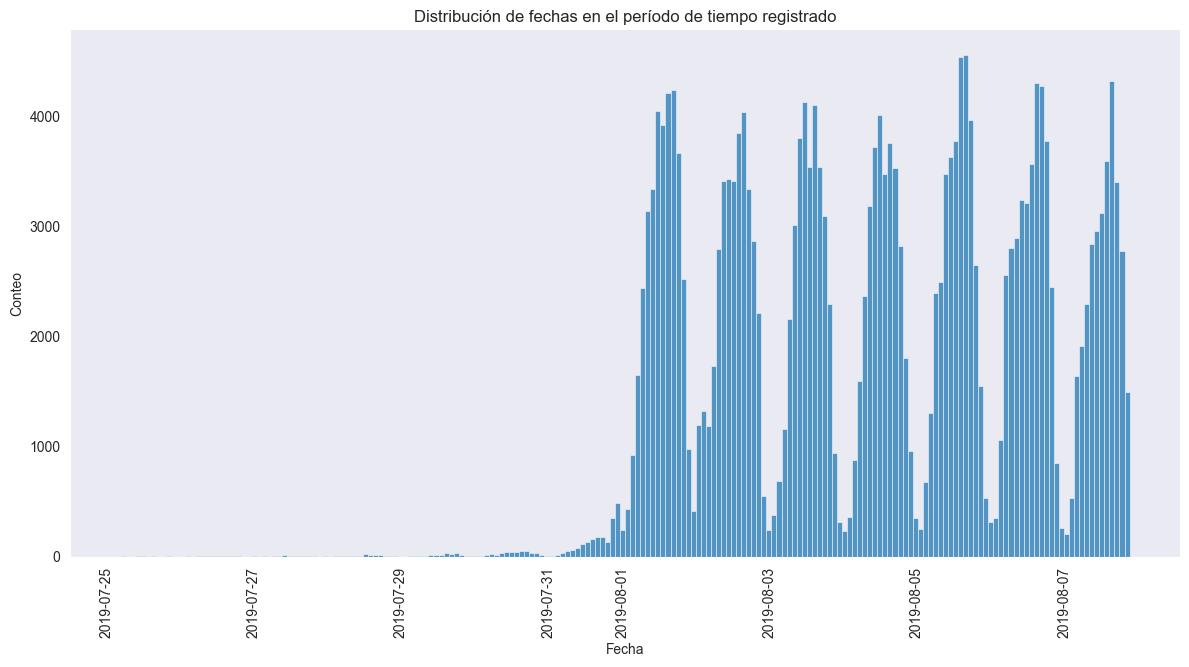

In [81]:
#Aplico el método describe() para obtener las fechas máximas y mínimas de los registros, y así, el período de tiempo
print('Descripicón general de la columna "date":')
print()
print(df['date'].describe())

#Genero un histograma para analizar las fechas y horarios de los eventos
sns.displot(df['date_hour'], bins=200, height=6, aspect=2)
plt.title('Distribución de fechas en el período de tiempo registrado')
plt.xlabel('Fecha')
plt.ylabel('Conteo')
plt.xticks(rotation=90)
sns.set_style('dark')

Se observa:  
* El período de tiempo de registros van desde el 2019-07-25 al 2019-08-07  
* Los registros comienzan a presentarse con mayor frecuencia a partir del 2019-07-31, sindo prácticamente nulos en los días anteriores.  

Lo observado indica que, de considerar los datos previos al día 07-31, se podría producir un sesgo en el panorama general, ya que estarían incompletos los datos, por lo que se decide excluir del análisis los registros previos a dicha fecha.

Dado que existe una gran variación de registros horarios, aún dentro de un mismo día, se grafica a continuación un histograma con los registros entre el día 07-31 18hs y el día 08-01 00hs, a fin de determinar el horario también donde cambian la cantidad de registros.

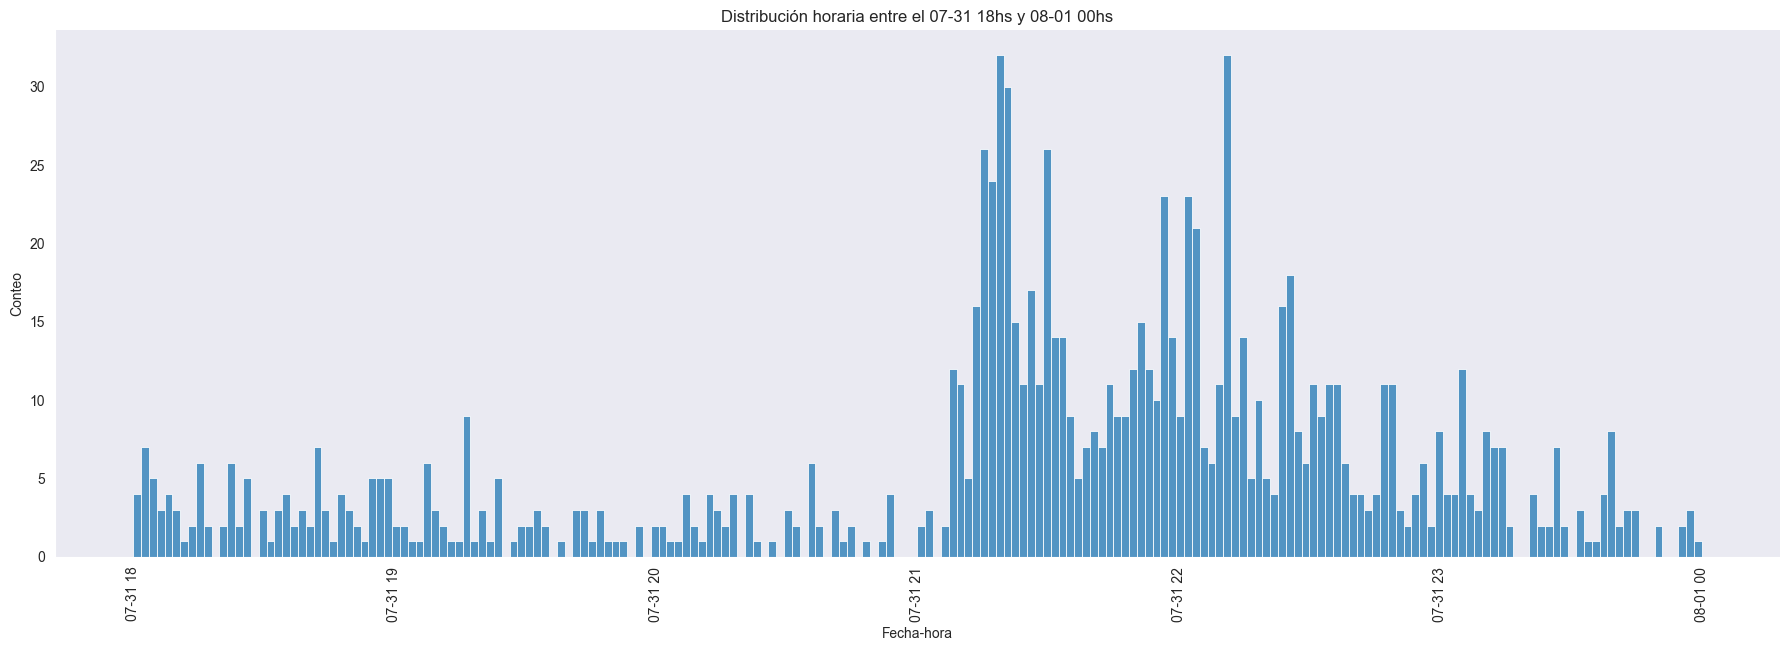

In [82]:
sns.displot(df.query('(date_hour >= "2019-07-31 18:00:00")&(date_hour <= "2019-08-01 00:00:00")')['date_hour'], bins=200, height=6, aspect=3)
plt.title('Distribución horaria entre el 07-31 18hs y 08-01 00hs')
plt.xlabel('Fecha-hora')
plt.ylabel('Conteo')
plt.xticks(rotation=90)
sns.set_style('dark')

Se observa que el cambio en los datos ocurre a las 21 hs del día 07-31, por lo que se elige dicho momento de corte para el nuevo período de tiempo con el que se filtrarán los datos.

,event_name,user_id,event_time,group,date_hour,date
1990,MainScreenAppear,7701922487875823903,1564606857,247,2019-07-31 21:00:57,2019-07-31
1991,MainScreenAppear,2539077412200498909,1564606905,247,2019-07-31 21:01:45,2019-07-31
1992,OffersScreenAppear,3286987355161301427,1564606941,248,2019-07-31 21:02:21,2019-07-31
1993,OffersScreenAppear,3187166762535343300,1564606943,247,2019-07-31 21:02:23,2019-07-31
1994,MainScreenAppear,1118952406011435924,1564607005,248,2019-07-31 21:03:25,2019-07-31




Descripicón general de la columna "date" en el nuevo período considerado:

count                           241724
mean     2019-08-03 22:29:13.086991616
min                2019-07-31 00:00:00
25%                2019-08-02 00:00:00
50%                2019-08-04 00:00:00
75%                2019-08-06 00:00:00
max                2019-08-07 00:00:00
Name: date, dtype: object


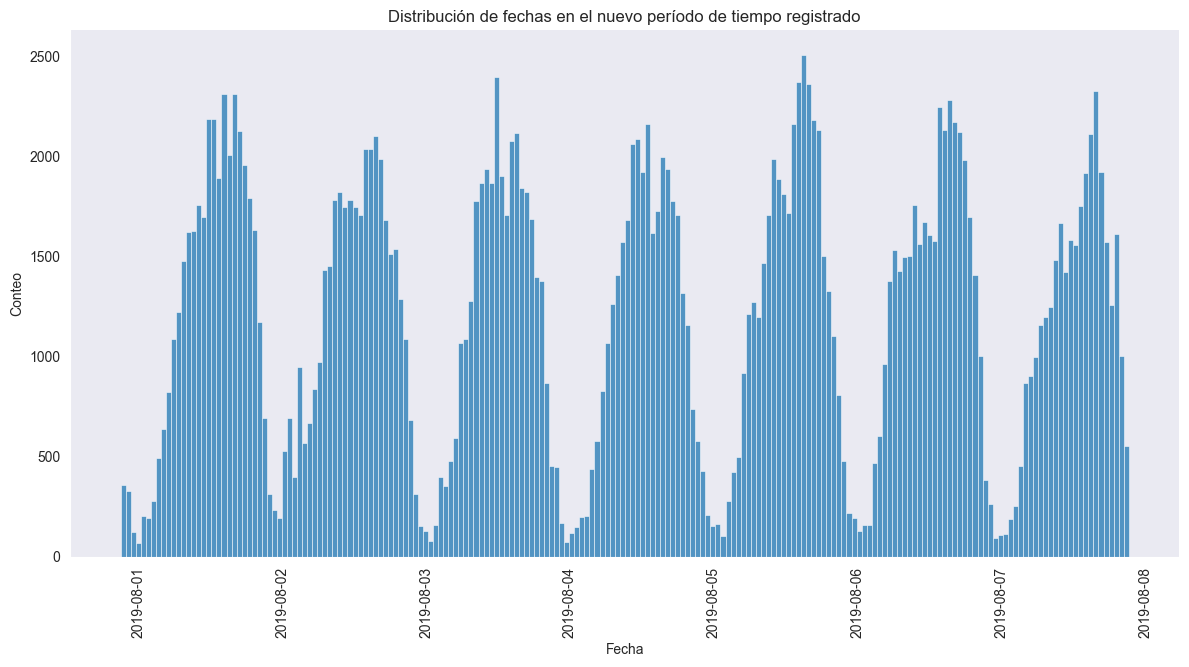

In [83]:
#Genero nuevo dataframe con los valores de fechas filtrados
df_new_dates = df.query('date_hour > "2019-07-31 21:00:00"')
display(df_new_dates.head())
print()
print()

#Aplico el método describe() para obtener las fechas máximas y mínimas de los registros en el dataframe filtrado
print('Descripicón general de la columna "date" en el nuevo período considerado:')
print()
print(df_new_dates['date'].describe())

#Genero nuevo histograma para el nuevo período de tiempo
sns.displot(df_new_dates['date_hour'], bins=200, height=6, aspect=2)
plt.title('Distribución de fechas en el nuevo período de tiempo registrado')
plt.xlabel('Fecha')
plt.ylabel('Conteo')
plt.xticks(rotation=90)
sns.set_style('dark')

### 3.5 Información perdida

Se verificará a continuación cuántos datos se perdieron por el filtrado del nuevo período de tiempo.

In [84]:
print('Dimensiones del dataframe de los valores que se excluyeron anteriormente:', df.query('~(date_hour > "2019-07-31 21:00:00")').shape)
print()
print('Porcentaje que representan del total:', df.query('~(date_hour > "2019-07-31 21:00:00")')['date_hour'].count() / df['date_hour'].count() * 100, '%')

Dimensiones del dataframe de los valores que se excluyeron anteriormente: (1989, 6)

Porcentaje que representan del total: 0.8161238834202524 %


Los registros perdidos representaban un 0.82% del total de registros, por lo que su exclusión no representa una incidencia significativa en el análisis.

### 3.6 Grupos experimentales

Se verifica rápidamente a continuación que existan usuarios en cada grupo de experimentación, calculando al mismo tiempo la cantidad de usuarios únicos en cada uno de los mismos.

In [85]:
df_new_dates.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
246,2484
247,2517
248,2537


## 4. Embudo de eventos

### 4.1 Eventos

Con el nuevo dataframe filtrado, se calcularán nuevamente los eventos que existen en los registros, así como la ocurrencia de los mismos, ordenados de mayor a menor.

In [86]:
events = df_new_dates.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False).reset_index()
events.columns = ['event_name', 'event_count']
events

,event_name,event_count
0,MainScreenAppear,117889
1,OffersScreenAppear,46531
2,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951
4,Tutorial,1010


### 4.2 Eventos y usuarios

Con el nuevo dataframe filtrado, se calcularán para cada evento la cantidad de usuarios únicos que realizaron los mismos, y se agregará la columna con la proporción de dichos usuarios respecto del total.

In [87]:
users = df_new_dates.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
users.columns = ['event_name', 'users']
users['ratio'] = users['users'] / users['users'].sum()
users

,event_name,users,ratio
0,MainScreenAppear,7423,0.368588
1,OffersScreenAppear,4597,0.228264
2,CartScreenAppear,3736,0.185511
3,PaymentScreenSuccessful,3540,0.175778
4,Tutorial,843,0.041859


### 4.3 Ocurrencia de acciones

Para los eventos contenidos en los registros, la cantidad de veces que cada uno es ejecutado, junto con la cantidad de usuarios que realizan los mismos, demuestran la posible secuencia de ocurrencia:  
1. Se visualiza la pantalla principal (Main screen appear)  
2. Se visualiza la pantalla de productos (Offers screen appear)  
3. Se visualiza el carrito de compras (Cart screen appear)  
4. Se efectúa el pago de la compra (Payment screen successful)  

Para el caso del evento "Tutorial", el cual posee la menor cantidad de registros, es probable que no necesariamente forme parte de los eventos secuencialmente, ya que tal vez únicamente los nuevos usuarios son los que necesitarían de ver el mismo, y tal vez se visualiza en cualquier parte del proceso. Por esto, se considera que este evento no necesita ser parte del embudo de eventos a estudiar.

### 4.4 Embudo de eventos

Se calcula a continuación el embudo de eventos según la secuencia descripta anteriormente.  
Para esto, inicialmente se creará una tabla dinámica con usuarios en filas, eventos en columnas, fecha y hora en valores, calculando la hora de la primera ocurrencia de cada evento.  
Luego se representará gráficamente el embudo de eventos.

In [88]:
users_events_pivot = df_new_dates.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='date_hour',
    aggfunc='min')

users_events_pivot.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


In [89]:
#Se colocan en variables las condiciones de filtrado de la tabla dinámica
#Se coloca la condición de horario mayor de una etapa a la siguiente, para asegurarnos que no existen etapas con horarios erróneos en el análisis
step_1 = ~users_events_pivot['MainScreenAppear'].isna()
step_2 = step_1 & (users_events_pivot['OffersScreenAppear'] > users_events_pivot['MainScreenAppear'])
step_3 = step_2 & (users_events_pivot['CartScreenAppear'] > users_events_pivot['OffersScreenAppear'])
step_4 = step_3 & (users_events_pivot['PaymentScreenSuccessful'] > users_events_pivot['CartScreenAppear'])

n_main_screen = users_events_pivot[step_1].shape[0]
n_offer_screen = users_events_pivot[step_2].shape[0]
n_cart_screen = users_events_pivot[step_3].shape[0]
n_payment_screen = users_events_pivot[step_4].shape[0]

print('Se visualiza la pantalla principal:', n_main_screen)
print('Se visualiza la pantalla de productos:', n_offer_screen)
print('Se visualiza el carrito de compras:', n_cart_screen)
print('Se efectúa el pago de la compra:', n_payment_screen)

Se visualiza la pantalla principal: 7423
Se visualiza la pantalla de productos: 4203
Se visualiza el carrito de compras: 1781
Se efectúa el pago de la compra: 458


In [90]:
fig = go.Figure(go.Funnel(
    y = ["MainScreenAppear","OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [n_main_screen, n_offer_screen,  n_cart_screen, n_payment_screen]
    ))
fig.show()

Se observa que el número de usuarios en la primera etapa coincide con el valor calculado anteriormente para la misma, pero en las etapas siguientes son diferentes. Esto quiere decir que no todos los usuarios toman la ruta prevista.

### 4.5 Etapas de pérdida

Según se observa en el embudo representado anteriormente, la etapa en donde más se pierden usuarios es en la correspondiente al pago exitoso (25.7% de la etapa previa), seguida por la etapa de visualización del carrito (42.4% de la etapa anterior).  

Esto puede indicar que existe algo en la página de pago que desmotiva a los usuarios a terminar con el proceso de compra.

### 4.6 Usuarios que concluyen el proceso

Según se observa en el embudo representado anteriormente, solamente el **6.2%** de los usuarios que tienen como primer evento la "visualización de la pantalla principal" llegan hasta el final del viaje, concluyendo con el pago.

## 5. Análisis del experimento A/A/B

### 5.1 Cantidad de usuarios por grupo

A continuación, se determina la cantidad de usuarios que están incluidos en cada grupo, donde:  
* Grupo 246: grupo de control (A) con las fuentes antiguas.  
* Grupo 247: grupo de control (A) con las fuentes antiguas.  
* Grupo 248: grupo de prueba (B) con las fuentes nuevas.  

También se crearán dataframes filtrados con los registros de cada grupo, visualizando su información general.

In [91]:
df_new_dates.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
246,2484
247,2517
248,2537


In [92]:
group_246 = df_new_dates.query('group == 246')
group_247 = df_new_dates.query('group == 247')
group_248 = df_new_dates.query('group == 248')
print('Grupo de control 246:')
print(group_246.info())
print()
print('Grupo de control 247:')
print(group_247.info())
print()
print('Grupo de prueba 248:')
print(group_248.info())

Grupo de control 246:
<class 'pandas.core.frame.DataFrame'>
Index: 79556 entries, 1996 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_name  79556 non-null  object        
 1   user_id     79556 non-null  int64         
 2   event_time  79556 non-null  int64         
 3   group       79556 non-null  int64         
 4   date_hour   79556 non-null  datetime64[ns]
 5   date        79556 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 4.2+ MB
None

Grupo de control 247:
<class 'pandas.core.frame.DataFrame'>
Index: 77293 entries, 1990 to 244121
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_name  77293 non-null  object        
 1   user_id     77293 non-null  int64         
 2   event_time  77293 non-null  int64         
 3   group       77293 non-null  int64     

### 5.2 Grupos de control - prueba A/A

Los grupos de control se utilizan para comprobar los mecanismos y cálculos.  

Se estudiará primeramente si hay una diferencia estadísticamente significativa entre ambos grupos. Para esto, se evaluará:  
* Si el número de usuarios de las muestras no varían en más del 1%.  
* Si ambas muestras no presentan una diferencia estadísticamente significativa, evaluando las proporciones entre cantidad de usuarios diferentes, y cantidades de registros de los mismos. Para esto, se utiliza el *estadístico* para analizar las siguientes hipótesis:  
    * Hipótesis nula: las proporciones de ambas muestras son iguales.
    * Hipótesis alternativa: las proporciones de ambas muestras son diferentes.

In [93]:
#Variación del número de usuarios
print('Usuarios únicos en grupo 246:', group_246['user_id'].nunique())
print('Usuarios únicos en grupo 247:', group_247['user_id'].nunique())
print()
print('Diferencia en cantidad de usuarios:', (abs(group_246['user_id'].nunique() - group_247['user_id'].nunique())/min(group_246['user_id'].nunique(), group_247['user_id'].nunique()))*100, '%')


Usuarios únicos en grupo 246: 2484
Usuarios únicos en grupo 247: 2517

Diferencia en cantidad de usuarios: 1.328502415458937 %


In [94]:
#Diferencia estadísticamente significativa en las proporciones de los grupos de control

alpha = 0.05 #Nivel de significación

control_users = np.array([group_246['user_id'].nunique(), group_247['user_id'].nunique()]) #Cantidad de usuarios únicos de cada grupo de control
control_total = np.array([group_246.shape[0], group_247.shape[0]]) #Cantidad de registros de cada grupo de control

p1 = control_users[0] / control_total[0]
p2 = control_users[1] / control_total[1]
p_combined = (control_users[0] + control_users[1]) / (control_total[0] + control_total[1])

difference = p1 - p2

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/control_total[0] + 1/control_total[1])) #Cálculo estadístico

distr = st.norm(0, 1) #Se establece la distribución normal estándar

p_value = (1 - distr.cdf(abs(z_value))) * 2 #Se calcula el p-value. Se multiplica por dos para considerar las dos colas de la curva.

print('p-value: ', p_value)

if p_value < alpha:
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

p-value:  0.13068747454697083
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Por lo observado, los grupos de control poseen una diferencia en cantidad de usuarios levemente superior al 1%, y se verifica que no hay una diferencia estadísticamente significativa en las proporciones entre usuarios y registros en ambos grupos de control.

### 5.3 Grupos de control - Proporciones de usuarios

Se estudiará a continuación para los grupos de control cuál es el evento más popular en cada uno y cuántos usuarios lo realizaron, calculando las proporciones de los mismos. Luego se analizará si las proporciones presentan una diferencia estadísticamente significativa.  

Posteriormente se repetirá dicho análisis para cada evento.  

Al analizar las proporciones, se definen las hipótesis:  
* Hipótesis nula: las proporciones de ambas muestras son iguales.
* Hipótesis alternativa: las proporciones de ambas muestras son diferentes.

In [95]:
#Dataframes con el conteo de registros de eventos de cada grupo

group_246_events = group_246.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False).reset_index()
group_246_events.columns = ['event_name', 'event_count']
print('Grupo de control 246:')
display(group_246_events)

print()

group_247_events = group_247.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False).reset_index()
group_247_events.columns = ['event_name', 'event_count']
print('Grupo de control 247:')
display(group_247_events)

Grupo de control 246:


,event_name,event_count
0,MainScreenAppear,37855
1,OffersScreenAppear,14829
2,CartScreenAppear,14697
3,PaymentScreenSuccessful,11858
4,Tutorial,317



Grupo de control 247:


,event_name,event_count
0,MainScreenAppear,39294
1,OffersScreenAppear,15237
2,CartScreenAppear,12439
3,PaymentScreenSuccessful,9983
4,Tutorial,340


El evento más ejecutado por ambos grupos de control es el **"MainScreenAppear"**.  
Se calculará a continuación la cantidad de usuarios que ejecutaron cada acción, para cada grupo, y su proporción del total de usuarios únicos.

In [96]:
#Dataframes con el conteo de usuarios por cada evento de cada grupo y sus proporciones del total

group_246_users = group_246.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
group_246_users.columns = ['event_name', 'users_count']
group_246_users['proportion'] = group_246_users['users_count'] / group_246['user_id'].nunique()
print('Grupo de control 246:')
display(group_246_users)

print()

group_247_users = group_247.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
group_247_users.columns = ['event_name', 'users_count']
group_247_users['proportion'] = group_247_users['users_count'] / group_247['user_id'].nunique()
print('Grupo de control 247:')
display(group_247_users)

Grupo de control 246:


,event_name,users_count,proportion
0,MainScreenAppear,2450,0.986312
1,OffersScreenAppear,1542,0.620773
2,CartScreenAppear,1266,0.509662
3,PaymentScreenSuccessful,1200,0.483092
4,Tutorial,278,0.111916



Grupo de control 247:


,event_name,users_count,proportion
0,MainScreenAppear,2479,0.984903
1,OffersScreenAppear,1524,0.605483
2,CartScreenAppear,1239,0.492253
3,PaymentScreenSuccessful,1158,0.460072
4,Tutorial,284,0.112833


A continuación se probará la hipótesis de igualdad de proporciones para cada evento, comenzando con el más popular.  

Se definirá una función que realice las pruebas de hipótesis para cada evento.

In [97]:
#Diferencia estadísticamente significativa en las proporciones de los grupos de control

alpha = 0.05 #Nivel de significación

In [98]:
#Función de prueba de hipótesis de proporciones

def test_hyp_proportion(df_1_users, df_1, df_2_users, df_2, name,sign_level):
    event_users = np.array([df_1_users.query('event_name == @name').iloc[0,1], df_2_users.query('event_name == @name').iloc[0,1]]) #Cantidad de usuarios únicos de cada grupo de control para el evento
    group_total = np.array([df_1['user_id'].nunique(), df_2['user_id'].nunique()]) #Cantidad de usuarios en total

    p1 = event_users[0] / group_total[0]
    p2 = event_users[1] / group_total[1]
    p_combined = (event_users[0] + event_users[1]) / (group_total[0] + group_total[1])

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_total[0] + 1/group_total[1])) #Cálculo estadístico

    distr = st.norm(0, 1) #Se establece la distribución normal estándar

    p_value = (1 - distr.cdf(abs(z_value))) * 2 #Se calcula el p-value. Se multiplica por dos para considerar las dos colas de la curva.

    print('p-value: ', p_value)

    if p_value < sign_level:
        print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
    else:
        print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

Se ejecuta para el evento más popular (MainScreenAppear), la prueba de hipótesis de proporciones:

In [99]:
event_1 = "MainScreenAppear"
print(f'Prueba de hipótesis para el evento {event_1}:')
test_hyp_proportion(group_246_users, group_246, group_247_users, group_247, event_1, alpha)

Prueba de hipótesis para el evento MainScreenAppear:
p-value:  0.6756217702005545
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


No parece haber una diferencia estadísticamente significativa entre las proporciones de los grupos de control para el evento más popular.  

A continuación, se realiza la misma prueba para el resto de los eventos:

In [100]:
event_2 = "OffersScreenAppear"
event_3 = "CartScreenAppear"
event_4 = "PaymentScreenSuccessful"
event_5 = "Tutorial"

print(f'Prueba de hipótesis para el evento {event_2}:')
test_hyp_proportion(group_246_users, group_246, group_247_users, group_247, event_2, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_3}:')
test_hyp_proportion(group_246_users, group_246, group_247_users, group_247, event_3, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_4}:')
test_hyp_proportion(group_246_users, group_246, group_247_users, group_247, event_4, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_5}:')
test_hyp_proportion(group_246_users, group_246, group_247_users, group_247, event_5, alpha)

Prueba de hipótesis para el evento OffersScreenAppear:
p-value:  0.26698769175859516
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento CartScreenAppear:
p-value:  0.2182812140633792
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento PaymentScreenSuccessful:
p-value:  0.10298394982948822
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento Tutorial:
p-value:  0.9182790262812368
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Conclusiones:  
Se confirma que los grupos se dividieron correctamente, ya que no parece existir una diferencia estadísticamente significativa entre las proporciones de los usuarios para cada evento.

### 5.4 Grupo de prueba B

Para el grupo de prueba B, se analizará también la cantidad de registros de cada evento, así como la cantidad de usuarios que realizó cada uno.  

Luego se irán comparando, para cada evento, las proporciones de usuarios que ejecutaron cada uno con las correspondientes a los grupos de control, probando si hay diferencias estadísticamente significativas para cada evento, con cada grupo de control, y luego para la combinación de ambos grupos de control.  

Por lo tanto, las pruebas que se harán serán:  
* 248 vs 246
* 248 vs 247
* 248 vs (246+247)

Se genera para el grupo de prueba B los dataframes de eventos y de usuarios.

In [101]:
#Dataframe con el conteo de registros de eventos
group_248_events = group_248.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False).reset_index()
group_248_events.columns = ['event_name', 'event_count']
print('Grupo de prueba 248:')
display(group_248_events)

print()

#Dataframe con el conteo de usuarios por evento y proporciones
group_248_users = group_248.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
group_248_users.columns = ['event_name', 'users_count']
group_248_users['proportion'] = group_248_users['users_count'] / group_248['user_id'].nunique()
display(group_248_users)

Grupo de prueba 248:


,event_name,event_count
0,MainScreenAppear,40740
1,OffersScreenAppear,16465
2,CartScreenAppear,15207
3,PaymentScreenSuccessful,12110
4,Tutorial,353


,event_name,users_count,proportion
0,MainScreenAppear,2494,0.983051
1,OffersScreenAppear,1531,0.603469
2,CartScreenAppear,1231,0.485219
3,PaymentScreenSuccessful,1182,0.465905
4,Tutorial,281,0.110761


Para visualizar en forma gráfica las proporciones para cada grupo, se representa en un diagrama a continuación las proporciones de usuarios que realizaron cada evento para cada grupo de control y el grupo de prueba. Para esto, se unifica en un único dataframe las proporciones de usuarios de cada grupo para cada evento.

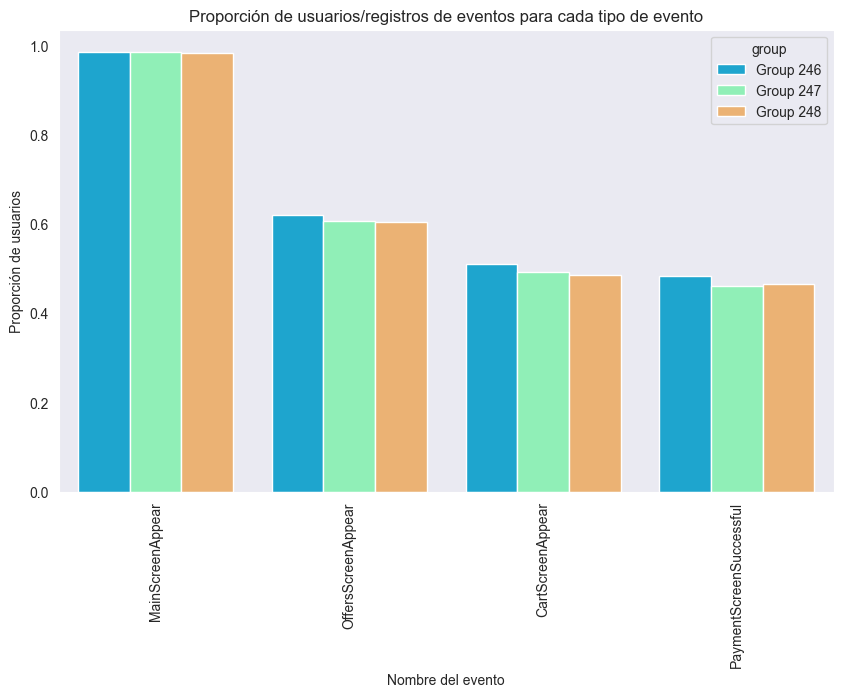

In [102]:
#Creo un dataframe concatenado con los datos de las proporciones a los fines de obtener el gráfico deseado
df1 = group_246_users[['event_name', 'proportion']].copy()
df2 = group_247_users[['event_name', 'proportion']].copy()
df3 = group_248_users[['event_name', 'proportion']].copy()

df1['group'] = 'Group 246'
df2['group'] = 'Group 247'
df3['group'] = 'Group 248'

groups_concat = pd.concat([df1, df2, df3])

#Elaboro un gráfico de barras para las proporciones de cada grupo, por eventos
plt.figure(figsize=(10, 6))
sns.barplot(x='event_name', y='proportion', data=groups_concat.query('~(event_name == "Tutorial")'), palette='rainbow', hue='group', legend=True)
plt.title('Proporción de usuarios/registros de eventos para cada tipo de evento')
plt.xlabel('Nombre del evento')
plt.ylabel('Proporción de usuarios')
plt.xticks(rotation=90)
sns.set_style('dark')

A continuación, se realizarán las pruebas de las hipótesis de diferencia estadísticamente significativa para las proporciones de usuarios por cada evento.

In [103]:
print('Pruebas 248 vs 246:')
print()
print(f'Prueba de hipótesis para el evento {event_1}:')
test_hyp_proportion(group_248_users, group_248, group_246_users, group_246, event_1, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_2}:')
test_hyp_proportion(group_248_users, group_248, group_246_users, group_246, event_2, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_3}:')
test_hyp_proportion(group_248_users, group_248, group_246_users, group_246, event_3, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_4}:')
test_hyp_proportion(group_248_users, group_248, group_246_users, group_246, event_4, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_5}:')
test_hyp_proportion(group_248_users, group_248, group_246_users, group_246, event_5, alpha)

Pruebas 248 vs 246:

Prueba de hipótesis para el evento MainScreenAppear:
p-value:  0.34705881021236484
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento OffersScreenAppear:
p-value:  0.20836205402738917
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento CartScreenAppear:
p-value:  0.08328412977507749
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento PaymentScreenSuccessful:
p-value:  0.22269358994682742
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento Tutorial:
p-value:  0.8964489622133207
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


In [104]:
print('Pruebas 248 vs 247:')
print()
print(f'Prueba de hipótesis para el evento {event_1}:')
test_hyp_proportion(group_248_users, group_248, group_247_users, group_247, event_1, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_2}:')
test_hyp_proportion(group_248_users, group_248, group_247_users, group_247, event_2, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_3}:')
test_hyp_proportion(group_248_users, group_248, group_247_users, group_247, event_3, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_4}:')
test_hyp_proportion(group_248_users, group_248, group_247_users, group_247, event_4, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_5}:')
test_hyp_proportion(group_248_users, group_248, group_247_users, group_247, event_5, alpha)

Pruebas 248 vs 247:

Prueba de hipótesis para el evento MainScreenAppear:
p-value:  0.6001661582453706
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento OffersScreenAppear:
p-value:  0.8835956656016957
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento CartScreenAppear:
p-value:  0.6169517476996997
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento PaymentScreenSuccessful:
p-value:  0.6775413642906454
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento Tutorial:
p-value:  0.8151967015119994
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Para las siguientes pruebas, donde se combinan los grupos 246 y 247, se creará un nuevo dataframe combinando ambos grupos de control.

In [105]:
group_control = df_new_dates.query('(group == 246)|(group == 247)')

group_control_users = group_control.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
group_control_users.columns = ['event_name', 'users_count']
group_control_users['proportion'] = group_control_users['users_count'] / group_control['user_id'].nunique()
display(group_control_users)


,event_name,users_count,proportion
0,MainScreenAppear,4929,0.985603
1,OffersScreenAppear,3066,0.613077
2,CartScreenAppear,2505,0.500900
3,PaymentScreenSuccessful,2358,0.471506
4,Tutorial,562,0.112378


In [106]:
print('Pruebas 248 vs (246 + 247):')
print()
print(f'Prueba de hipótesis para el evento {event_1}:')
test_hyp_proportion(group_248_users, group_248, group_control_users, group_control, event_1, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_2}:')
test_hyp_proportion(group_248_users, group_248, group_control_users, group_control, event_2, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_3}:')
test_hyp_proportion(group_248_users, group_248, group_control_users, group_control, event_3, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_4}:')
test_hyp_proportion(group_248_users, group_248, group_control_users, group_control, event_4, alpha)
print()
print(f'Prueba de hipótesis para el evento {event_5}:')
test_hyp_proportion(group_248_users, group_248, group_control_users, group_control, event_5, alpha)

Pruebas 248 vs (246 + 247):

Prueba de hipótesis para el evento MainScreenAppear:
p-value:  0.39298914928006035
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento OffersScreenAppear:
p-value:  0.418998284007599
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento CartScreenAppear:
p-value:  0.19819340844527744
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento PaymentScreenSuccessful:
p-value:  0.6452057673098244
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes

Prueba de hipótesis para el evento Tutorial:
p-value:  0.8333049080125807
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Conclusiones del experimento:  
Se observa que las proporciones de usuarios por cada evento en las tres pruebas de hipótesis realizadas no presentan diferencias estadísticamente significativas, esto implicaría que el cambio propuesto para el grupo de prueba B no cambió las conversiones a cada etapa de los usuarios.

### 5.5 Nivel de significación

Para las pruebas de hipótesis realizadas anteriormente se utilizó un nivel de significancia estadística de 5% (0.05), y se realizaron en total 3 pruebas de hipótesis (3 para cada uno de los 5 eventos).

In [107]:
n_test = 3
print('La probabilidad de un falso positivo en las pruebas es:', (1 - (1 - alpha)**n_test)*100, '%')

La probabilidad de un falso positivo en las pruebas es: 14.262500000000012 %


La probabilidad de tener un falso positivo en las pruebas de hipótesis es del 14.26%.  
Al tratarse de múltiples pruebas de hipótesis, el nivel de significancia se debe corregir, para lo cual se adopta a continuación la corrección de Bonferroni, por ser la de mayor simplicidad:

In [108]:
alpha_fix = alpha / n_test
alpha_fix

0.016666666666666666

El nivel de significancia corregido quedaría en 1.6%, y dado que los p-value de todas las pruebas dieron superiores al 5%, la corrección del nivel de significancia no cambiaría los resultados de las pruebas de hipótesis.

## 6. Conclusiones

Se evaluó el comportamiento de los usuarios en la aplicación de una empresa de venta de productos alimenticios. En el análisis, se estudiaron dos aspectos:  
* Embudo de ventas, donde se evaluó el comportamiento en general de todos los usuarios, en base a un camino lógico que termina en el pago exitoso de la compra.  
* Pruba sobre un experimento A/A/B con el cambio de las fuentes de la aplicación, en donde se analizó si se vio modificado el comportamiento de los grupos de usuarios que participaron de uno u otro grupo de prueba.  

Conclusiones:  
* Embudo de ventas:  
    * Se observa que, del 100% de usuarios que comienzan con el menú principal de la aplicación (MainScreenAppear), solamente el **6.2%** concluye el proceso de compra y pago.  
    * Asimismo se observa que la etapa en donde más se pierden usuarios es justamente en la correspondiente al pago exitoso (25.7% de la etapa previa), y seguida por la etapa de visualización del carrito (42.4% de la etapa anterior). Esto puede indicar que existe algo en la página de pago que desmotiva a los usuarios a terminar con el proceso de compra.  

* Análisis del experimento:  
    * Se observa que no parece existir una diferencia estadísticamente significativa entre las proporciones de los usuarios en los grupos de control, ni en general, ni para cada evento, por lo que se considera que los mismos se dividieron correctamente.  
    * Se observa por las pruebas estadísticas que el grupo de prueba no presenta diferencias estadísticamente significativas en las proporciones de usuarios, respecto a los grupos de control, lo cual implicaría que el cambio propuesto en la aplicación para el grupo de prueba no modificó significativamente las conversiones a cada etapa de los usuarios.